In [53]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [54]:
data = pd.read_csv('data/umist_cropped_with_cluster_id_training.csv')
val_data = pd.read_csv(r'data\validation_data\umist_cropped_with_cluster_id_val.csv')
test_data = pd.read_csv('data/test_data/umist_test.csv')

In [55]:
X_train = data.drop(['cluster_id'],axis = 1)
y_train = data['cluster_id']

X_val = val_data.drop(['cluster_id'],axis = 1)
y_val = val_data['cluster_id']

X_test = test_data

In [56]:
y_train -= 1
y_val -= 1

In [57]:
# Extract pixel values and reshape
X_train = X_train.values.reshape(-1, 112, 92, 1)

X_val = X_val.values.reshape(-1, 112, 92, 1)

X_test = X_test.values.reshape(-1, 112, 92, 1)

In [58]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [59]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [60]:
print(f"Image tensor shape: {X_train.shape}")  # Should print (num_samples, 112, 92, 1)

Image tensor shape: (600, 112, 92, 1)


In [61]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 20
NUMBER_OF_TRAINING_IMAGES = 600

In [62]:
model = models.Sequential()

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [63]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 112, 92, 512)   │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 54, 44, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 27, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614,874 (17.60 MB)

 Trainable params: 4,614,874 (17.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
)

model_checkpoint = ModelCheckpoint(
    filepath='models/classifier/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)


In [65]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [66]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.0959 - loss: 14.2824
Epoch 1: val_accuracy improved from -inf to 0.15044, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 921ms/step - accuracy: 0.0961 - loss: 14.2181 - val_accuracy: 0.1504 - val_loss: 10.4084
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.1678 - loss: 9.4481
Epoch 2: val_accuracy improved from 0.15044 to 0.25664, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 849ms/step - accuracy: 0.1697 - loss: 9.4064 - val_accuracy: 0.2566 - val_loss: 6.9292
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.2381 - loss: 6.4523
Epoch 3: val_accuracy improved from 0.25664 to 0.51327, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 810ms/step - accuracy: 0.2402 - loss: 6.4234 - val_accuracy: 0.5133 - val_loss: 4.5028
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.4

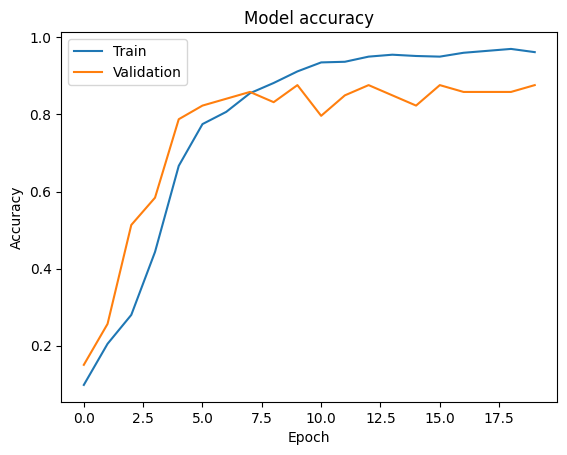

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

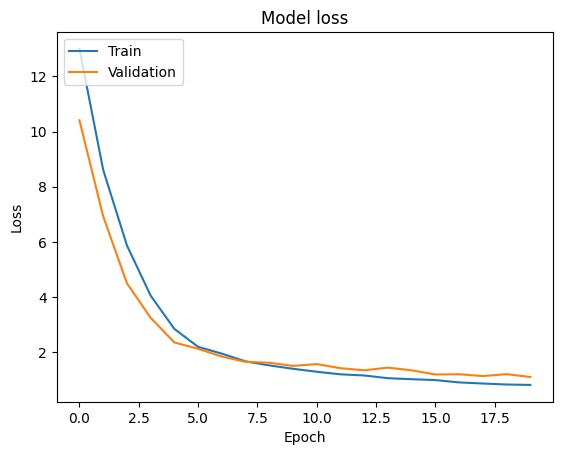

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [70]:
y_test_pred = model.predict(tf.expand_dims(X_test[2], axis=0))

print(f"Predicted class: {np.argmax(y_test_pred) + 1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: 1


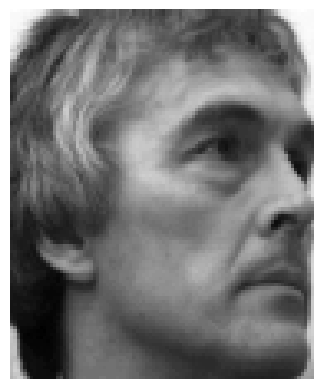

In [71]:
plt.imshow(X_test[2].numpy().reshape(112, 92), cmap='gray')
plt.axis('off')
plt.show()